_This notebook contains all the sample code for LSTM_

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast", markersize=8)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

# LSTM

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
f_stepts = 10
series = generate_time_series(10000, n_steps + f_stepts)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, f_stepts))
for step_ahead in range(1, f_stepts + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model = keras.models.Sequential([
    keras.layers.LSTM(5, return_sequences=True, input_shape=[None, 1]),
    keras.layers.TimeDistributed(keras.layers.Dense(f_stepts))
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid))

Epoch 1/30
219/219 [==============================] - 12s 38ms/step - loss: 0.1448 - val_loss: 0.0838
Epoch 2/30
219/219 [==============================] - 7s 32ms/step - loss: 0.0752 - val_loss: 0.0619
Epoch 3/30
219/219 [==============================] - 7s 30ms/step - loss: 0.0612 - val_loss: 0.0576
Epoch 4/30
219/219 [==============================] - 7s 31ms/step - loss: 0.0571 - val_loss: 0.0552
Epoch 5/30
219/219 [==============================] - 7s 32ms/step - loss: 0.0547 - val_loss: 0.0534
Epoch 6/30
219/219 [==============================] - 7s 32ms/step - loss: 0.0532 - val_loss: 0.0519
Epoch 7/30
219/219 [==============================] - 6s 29ms/step - loss: 0.0515 - val_loss: 0.0506
Epoch 8/30
219/219 [==============================] - 7s 32ms/step - loss: 0.0506 - val_loss: 0.0496
Epoch 9/30
219/219 [==============================] - 7s 30ms/step - loss: 0.0493 - val_loss: 0.0489
Epoch 10/30
219/219 [==============================] - 7s 31ms/step - loss: 0.0490 - val_l

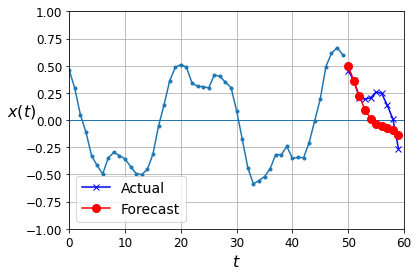

In [7]:
series = generate_time_series(1, 50 + f_stepts)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2d56399-109c-41f5-95dd-f778a8b8bb55' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>